In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import intake,yaml
import intake_esm
from scipy import special
import keras
from keras.models import Model
from keras.layers import Dense, Input

from netCDF4 import Dataset
import scipy as sp
import scipy.io as sp_io
from mpl_toolkits.basemap import Basemap, cm, shiftgrid
import seaborn as sns
from matplotlib.colors import ListedColormap
colours=sns.color_palette('colorblind', 10)
my_cmap = ListedColormap(colours)

## Retrieve for the data (here example of IPSL-1%Co2)

for the other models and scenarios, please change the variable "expname_filter" and "model_filter"

In [2]:
col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col = intake.open_esm_datastore(col_url)

In [3]:
%pwd

'/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels'

In [4]:
#define location of weights file and image output here
import sys,os
wgtsdir = "../../ensembleMLP"
imgdir = "png_4pctCO2_IPSL"
if(os.path.exists(wgtsdir)):
    print("weight dir exists")
else:
    sys.exit("weights directory is invalid")
if(os.path.exists(wgtsdir+'/vanillamodel_0.h5')):
    print("weight file exists")
else:
    sys.exit("weights directory is invalid:"+wgtsdir+'/vanillamodel_0.h5')   
    
if not os.path.exists(imgdir):
    os.makedirs(imgdir)


weight dir exists
weight file exists


In [75]:
#Examples to just search for what we want from the catalog
expname_filter = ['abrupt-4xCO2']
table_id_filter = 'Omon'
model_filter = 'IPSL-CM6A-LR'
#variable_id_filter = "zos"
grid_label_filter = 'gn'
ens_filter = "r1i1p1f1"
version_filter = "v20190118"
temporal_subset_filter =  "245001-274912"

cat = col.search(experiment_id=expname_filter,
                 mip_table=table_id_filter,
                 model=model_filter,
                 variable=['zos'],
                 grid_label=grid_label_filter,
                 ensemble_member = ens_filter,
                 version = version_filter,
                 
                 
                )

col_tauuo = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['tauuo'],
                       ensemble_member = ens_filter,
                       version = version_filter
                       )

col_tauvo = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['tauvo'],
                       ensemble_member = ens_filter,
                       version = version_filter
                       )

col_bathm = col.search(experiment_id=['1pctCO2'],
                       model=model_filter,
                       mip_table='Ofx',
                       grid_label=grid_label_filter,
                       variable='deptho'
                       )

In [70]:
cat

,unique
project,1
institute,1
model,1
experiment_id,1
frequency,1
modeling_realm,1
mip_table,1
ensemble_member,1
grid_label,1
variable,1


In [65]:
cat.df


,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,zos,185001-214912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
1,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,zos,215001-244912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
2,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,zos,245001-274912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...


In [47]:
col_bathm.df

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,1pctCO2,NaN,NaN,Ofx,r1i1p1f1,gn,deptho,NaN,v20180727,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/1...


In [48]:
col_tauuo.df

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauuo,185001-214912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
1,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauuo,215001-244912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
2,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauuo,245001-274912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...


In [49]:
col_tauvo.df

,project,institute,model,experiment_id,frequency,modeling_realm,mip_table,ensemble_member,grid_label,variable,temporal subset,version,path
0,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauvo,185001-214912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
1,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauvo,215001-244912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...
2,CMIP6,IPSL,IPSL-CM6A-LR,abrupt-4xCO2,mon,ocean,Omon,r1i1p1f1,gn,tauvo,245001-274912,v20190118,s3://esgf-world/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/a...


### Read data

In [83]:
dset_dict_zos = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/

In [85]:
dset_dict_zos

{'CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon': <xarray.Dataset>
 Dimensions:          (axis_nbounds: 2, ensemble_member: 1, nvertex: 4, time: 10800, x: 362, y: 332)
 Coordinates:
     nav_lat          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     nav_lon          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
   * time             (time) object 1850-01-16T12:00:00 ... 2749-12-16 12:00:00
   * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
 Dimensions without coordinates: axis_nbounds, nvertex, x, y
 Data variables:
     bounds_nav_lon   (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     bounds_nav_lat   (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     area             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     time_bounds      (time, axis_nbounds) object dask.array<chunksize=(20, 2), meta=np.ndarray>
     zos              (ensemble_member, time, y, x) f

In [52]:
dset_dict_zos.keys()

dict_keys(['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon'])

In [53]:
dset_dict_tauuo = col_tauuo.to_dataset_dict(cdf_kwargs={'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/

In [84]:
dset_dict_tauuo

{'CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon': <xarray.Dataset>
 Dimensions:          (axis_nbounds: 2, ensemble_member: 1, nvertex: 4, time: 10800, x: 362, y: 332)
 Coordinates:
     nav_lat          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     nav_lon          (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
   * time             (time) object 1850-01-16T12:00:00 ... 2749-12-16 12:00:00
   * ensemble_member  (ensemble_member) <U8 'r1i1p1f1'
 Dimensions without coordinates: axis_nbounds, nvertex, x, y
 Data variables:
     bounds_nav_lon   (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     bounds_nav_lat   (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
     area             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
     time_bounds      (time, axis_nbounds) object dask.array<chunksize=(20, 2), meta=np.ndarray>
     tauuo            (ensemble_member, time, y, x) f

In [54]:
dset_dict_zos.keys()

dict_keys(['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon'])

In [55]:
dset_dict_tauvo = col_tauvo.to_dataset_dict(cdf_kwargs={'chunks': {'time': 20}}, storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/home/jovyan/my-conda-envs/enso_ml/lib/

In [56]:
dset_dict_zos.keys()

dict_keys(['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon'])

In [57]:
dset_dict_bathm = col_bathm.to_dataset_dict(storage_options={'anon':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institute.model.experiment_id.mip_table'


In [61]:
#these dictionaries have only key value that's why they are all identical
zos_xr = dset_dict_zos['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon'] 
tauuo_xr = dset_dict_tauuo['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon']
tauvo_xr = dset_dict_tauvo['CMIP6.IPSL.IPSL-CM6A-LR.abrupt-4xCO2.Omon']
#This is the diiferent one among them
bathm_xr = dset_dict_bathm["CMIP6.IPSL.IPSL-CM6A-LR.1pctCO2.Ofx"]

### Some plotting

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


TypeError: '<' not supported between instances of 'cftime._cftime.DatetimeGregorian' and 'str'

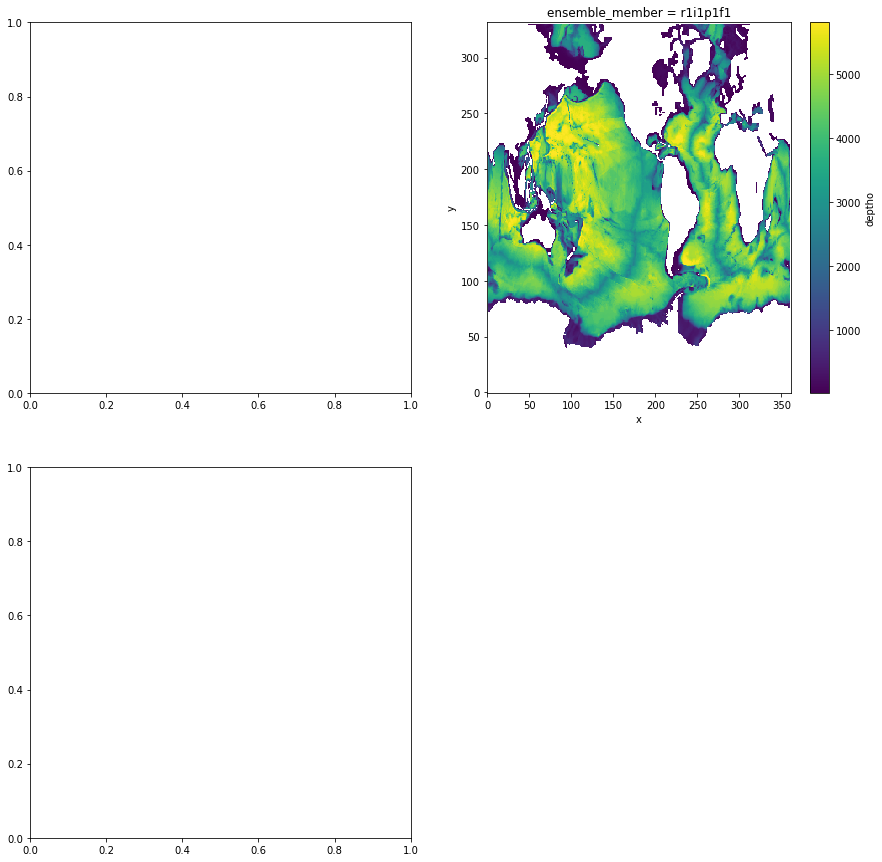

In [82]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
#zos_xr.zos.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,2)
bathm_xr.deptho[0,:,:,:].max(axis=0).plot()

plt.subplot(2,2,3)
tauuo_xr.tauuo.sel(time=slice("1992", "2011")).mean(axis=1).plot()

plt.subplot(2,2,4)
tauvo_xr.tauvo.sel(time=slice("1992", "2011")).mean(axis=1).plot()


### Preparing the features for the EnsembleMLP

In [17]:
def grad(d,y,x):
    "Returns a three point derivative."
    g0, g1 = np.gradient(d)
    grady=g0/y
    gradx=g1/x
    return grady, gradx

In [18]:
Bathm = bathm_xr.deptho[0,:,:,:].max(axis=0)  ###This is specific to IPSL bathymetry
####
lonRoll = np.roll(Bathm.nav_lon.values, axis=1, shift=-1)
Londiff = lonRoll - Bathm.nav_lon.values
latDiff=1.111774765625000e+05
latY=np.gradient(Bathm.nav_lat.values, axis=0)*latDiff
lonX=np.abs(np.cos(Bathm.nav_lat.values*np.pi/180))*latDiff*Londiff
####
Omega=7.2921e-5
f=(2*Omega*np.sin(Bathm.nav_lat.values*np.pi/180))

In [19]:
from pickle import load
#######!!!!!! it might ask you to use scikit-learn 0.22.2.post1 !!!!!! check if you get the good .mean_ and .scale_
#(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
#         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
# array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
#        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))
scaler = load(open('scaler_v1.pkl', 'rb'))

/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [20]:
scaler.mean_, scaler.scale_

(array([-2.20681035e-11,  7.85894841e-03,  1.92149912e-08,  1.38805767e-07,
         3.96657293e+03, -1.45941754e-04,  5.42086609e-04, -1.21754470e-05]),
 array([1.46399667e-10, 7.07289355e-01, 1.89893314e-07, 4.55081599e-07,
        1.44475515e+03, 4.87804804e-03, 4.64697134e-03, 9.54868121e-05]))

In [21]:
listyears = ["1872","1891","1892","1911","1912","1931","1932","1951","1952","1971","1972","1991","1992","2011"]

In [ ]:
datapredicted_results = np.nan * np.zeros((7,)+Bathm.shape)

for i in range(7):
    
    print(listyears[2*i]+listyears[2*i+1])
    SSH20Mean = zos_xr.zos.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauUOMean = tauuo_xr.tauuo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values
    TauVOMean = tauvo_xr.tauvo.isel(ensemble_member=0).sel(time=slice(listyears[2*i], listyears[2*i+1])).mean(axis=0).values

    ####
    print('Calculate grads')
    gradSSH_y, gradSSH_x = grad(SSH20Mean,latY,lonX)
    gradBathm_y, gradBathm_x = grad(Bathm,latY,lonX)
    gradUx_y, gradUx_x = grad(TauUOMean,latY,lonX)
    gradUy_y, gradUy_x = grad(TauVOMean,latY,lonX)
    ####
    print('Calculate CurlTau')
    curlTau =(gradUy_x-gradUx_y)/1032
    
    ####
    print('Calculate missindx')
    missingdataindex = np.isnan(curlTau*SSH20Mean*
                                   gradSSH_x*gradSSH_y*
                                   Bathm*gradBathm_x*
                                   gradBathm_y*f)
    ####
    print('Creating TotalDataset')
    TotalDataset = np.stack((curlTau[~missingdataindex],
                         SSH20Mean[~missingdataindex],
                         gradSSH_x[~missingdataindex],
                         gradSSH_y[~missingdataindex],
                         Bathm.values[~missingdataindex],
                         gradBathm_x[~missingdataindex],
                         gradBathm_y[~missingdataindex],
                         f[~missingdataindex]),1)
    ####
    print('NN pred')
    
    datapredicted_results_vanilla_ensemble = np.nan * np.zeros((50,TotalDataset.shape[0],6))

    for j in range(50):
        I1 = Input(shape=(8,)) 
        h1 = Dense(24, activation='tanh')(I1)
        h1 = Dense(24, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        h1 = Dense(16, activation='tanh')(h1)
        Output = Dense(6, activation='softmax')(h1)
        vanillamodel = Model(I1, Output)
        vanillamodel.load_weights(wgtsdir+'/vanillamodel_'+str(j)+'.h5') ###path in github repo
        datapredicted = vanillamodel.predict(scaler.transform(TotalDataset))#a1r
        datapredicted_results_vanilla_ensemble[j,...] = datapredicted
        
    tmpMean = np.mean(datapredicted_results_vanilla_ensemble,0)
    tmpSoftmax = special.softmax(tmpMean,1)
    datapredicted_results[i,:,:][~missingdataindex] = np.argmax(tmpSoftmax, 1)

    
np.save('/home/jovyan/DNN4Cli/THOR/ApplicationOnCMIPModels/IPSL-1pctCO2-198701-201112-EnsembleMLP.npy',datapredicted_results)
    

18721891


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


18921911


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19121931


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19321951


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


19521971


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Calculate grads


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


Calculate CurlTau
Calculate missindx
Creating TotalDataset


/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/utils.py:34: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/jovyan/my-conda-envs/enso_ml/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/

NN pred


In [68]:
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['royalblue', 'cyan','yellow', 'orange', 'magenta', 'red'])

In [41]:
ecco_label = np.load('eccolabel.npy')

Text(0.5, 1.0, 'ECCO regimes 1992-2011')

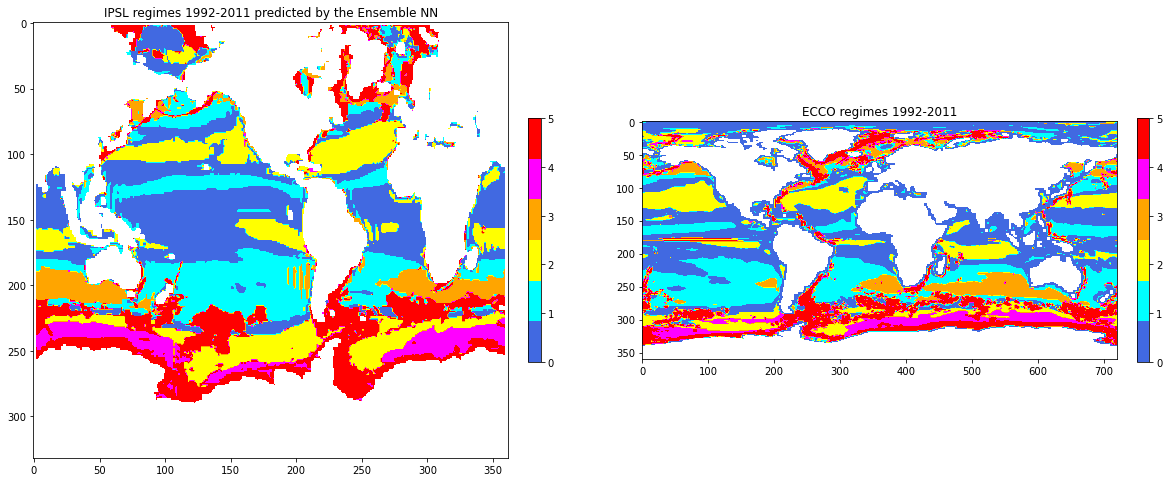

In [69]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(datapredicted_results[-1,:,:][::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('IPSL regimes 1992-2011 predicted by the Ensemble NN (1%CO2)')

plt.subplot(1,2,2)
plt.imshow(ecco_label[::-1,:], cmap=mycmap)
plt.colorbar(fraction=0.024, pad=0.04)
plt.title('ECCO regimes 1992-2011 (1%CO2)')

# Save the images for the 20 years chunks

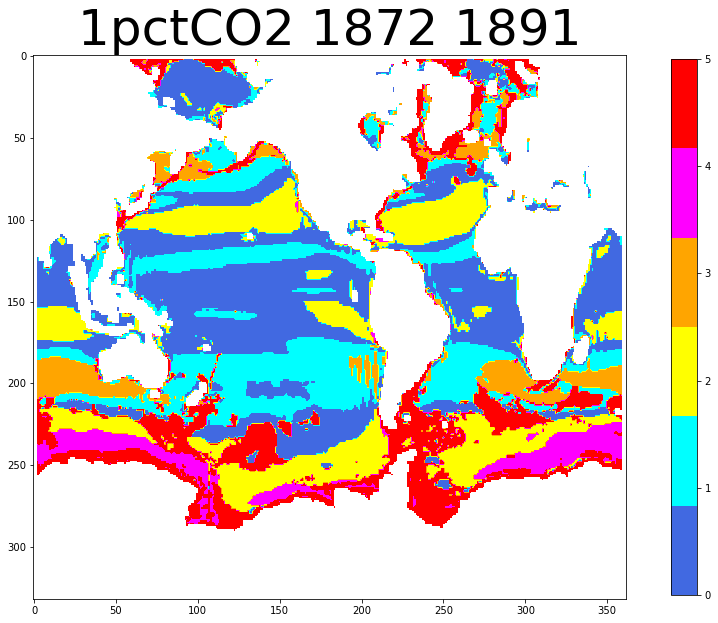

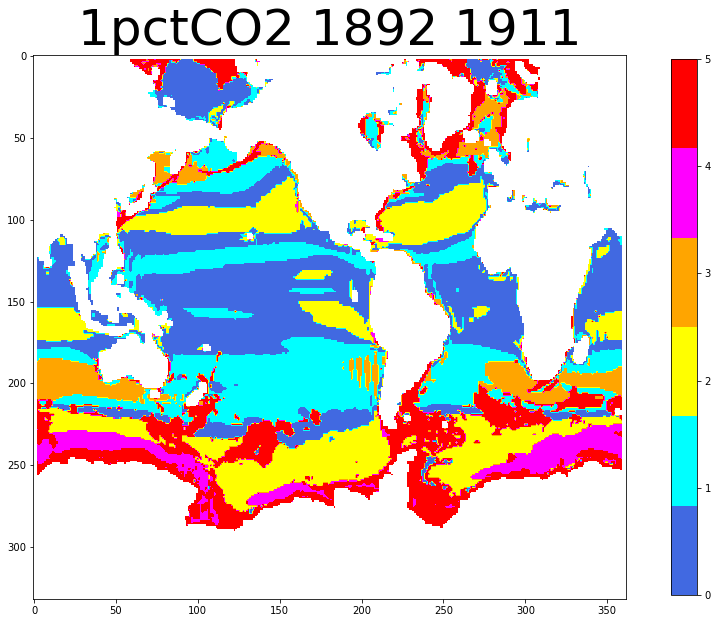

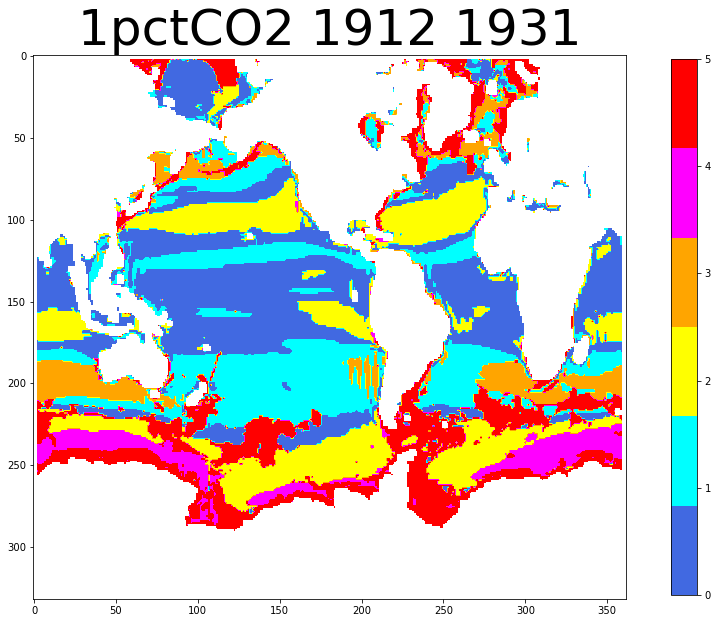

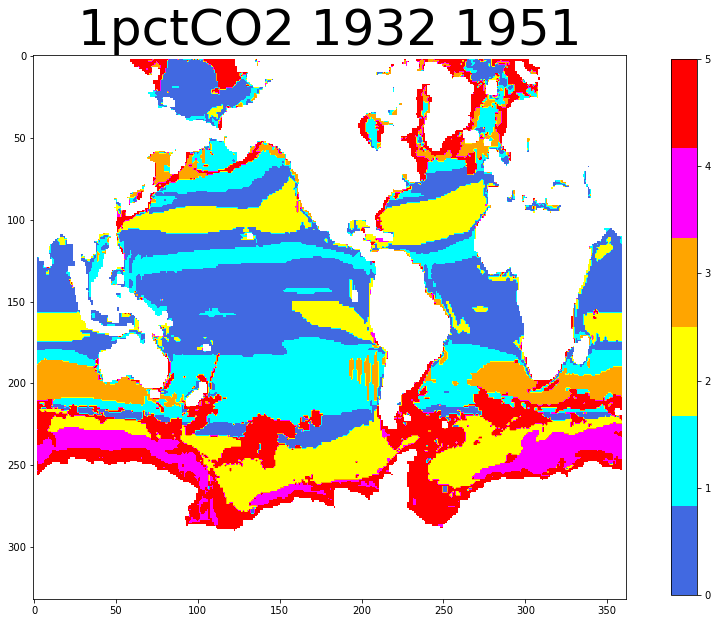

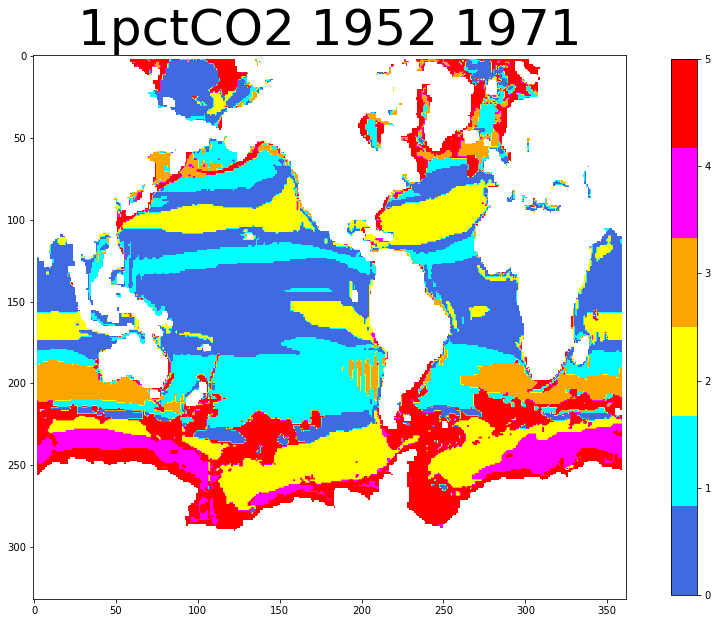

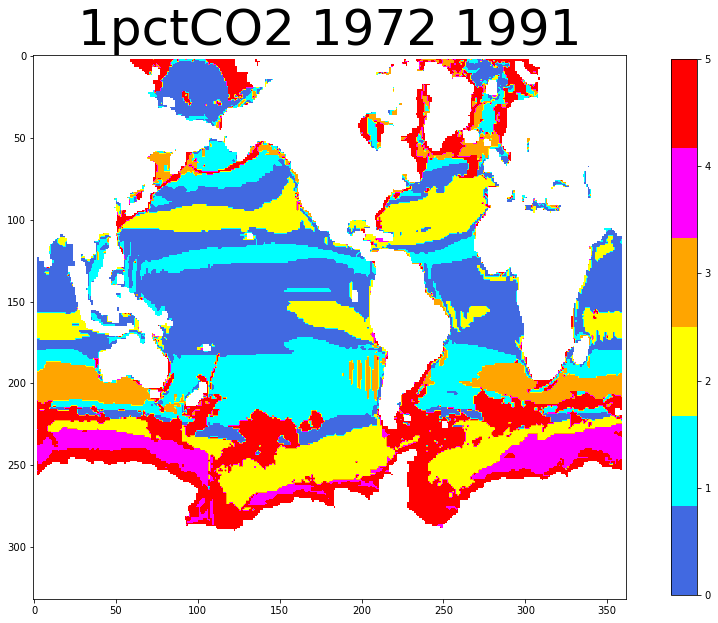

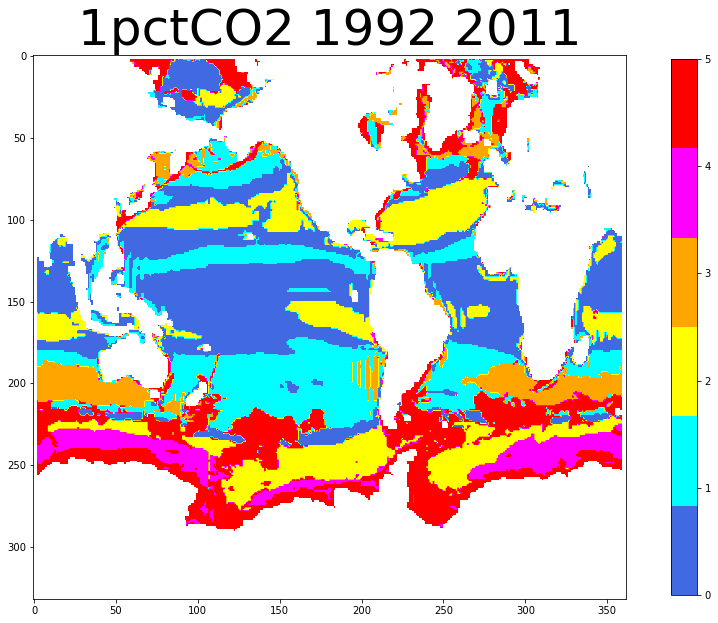

In [79]:
for i in range(7):
    plt.figure(figsize=(20,10))
    #plt.subplot(1,2,1)
    plt.imshow(datapredicted_results[i,:,:][::-1,:], cmap=mycmap)
    plt.colorbar(fraction=0.024, pad=0.04)
    plt.title('1%CO2 '+str(listyears[2*i])+' '+str(listyears[2*i+1]), fontsize=50)
    plt.savefig('png_1pctCO2_IPSL'+str(listyears[2*i])+str(listyears[2*i+1])+'.png')

## create a gif

In [81]:
import os
import imageio

png_dir = 'png_1pctCO2_IPSL/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('png_Historical_IPS/IPSL-png_Historical.gif', images, fps=1)

## Retrieve for the data (here example of IPSL-1%CO2)

In [5]:
#define location of weights file and image output here
import sys,os
wgtsdir = "../../ensembleMLP"
imgdir = "png_historical_IPSL"
if(os.path.exists(wgtsdir)):
    print("weight dir exists")
else:
    sys.exit("weights directory is invalid")
if(os.path.exists(wgtsdir+'/vanillamodel_0.h5')):
    print("weight file exists")
else:
    sys.exit("weights directory is invalid:"+wgtsdir+'/vanillamodel_0.h5')   
    
if not os.path.exists(imgdir):
    os.makedirs(imgdir)


weight dir exists
weight file exists


In [13]:
#Examples to just search for what we want from the catalog
expname_filter = ['1pctCO2']

cat_1pct = col.search(experiment_id=expname_filter,
                 mip_table=table_id_filter,
                 model=model_filter,
                 variable=['zos'],
                 grid_label=grid_label_filter,
                 ensemble_member = ens_filter
                )

col_tauuo_1pct = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['tauuo'],
                       ensemble_member = ens_filter
                       )

col_tauvo_1pct = col.search(experiment_id=expname_filter,
                       model=model_filter,
                       mip_table=table_id_filter,
                       grid_label=grid_label_filter,
                       variable=['tauvo'],
                       ensemble_member = ens_filter
                       )

col_bathm_1pct = col.search(experiment_id=['1pctCO2'],
                       model=model_filter,
                       mip_table='Ofx',
                       grid_label=grid_label_filter,
                       variable='deptho'
                       )